In [51]:
import findspark

findspark.init()

In [52]:
import pyspark

from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

df = spark.sql("select 'spark' as hello ")

df.show()


+-----+
|hello|
+-----+
|spark|
+-----+



In [53]:
spark

In [ ]:
# configure spark variables
from pyspark.context import SparkContext
from pyspark.sql.context import SQLContext
from pyspark.sql.session import SparkSession
   
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)
spark = SparkSession(sc)

# load up other dependencies
import re
import pandas as pd

In [55]:
sqlContext

IMPORTING NASA LOG DATA

In [57]:
import glob

raw_data_files = glob.glob(r'C:\Users\sjdki\Desktop\Netacea project\Nasa data\access*')
print(raw_data_files)

['C:\\Users\\sjdki\\Desktop\\Netacea project\\Nasa data\\access_log_Aug95.txt', 'C:\\Users\\sjdki\\Desktop\\Netacea project\\Nasa data\\access_log_Jul95.txt']


In [58]:
base_df = spark.read.text(raw_data_files)
base_df.printSchema()

root
 |-- value: string (nullable = true)



In [59]:
type(base_df)


pyspark.sql.dataframe.DataFrame

Initial Look at the Data

In [61]:
base_df.show(10, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                     |
+--------------------------------------------------------------------------------------------------------------------------+
|in24.inetnebr.com - - [01/Aug/1995:00:00:01 -0400] "GET /shuttle/missions/sts-68/news/sts-68-mcc-05.txt HTTP/1.0" 200 1839|
|uplherc.upl.com - - [01/Aug/1995:00:00:07 -0400] "GET / HTTP/1.0" 304 0                                                   |
|uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/ksclogo-medium.gif HTTP/1.0" 304 0                          |
|uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/MOSAIC-logosmall.gif HTTP/1.0" 304 0                        |
|uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/USA-logosmall.gif HTTP/1.0" 304 0                           |


Data Parsing with Regular Expression

In [62]:
print((base_df.count(), len(base_df.columns)))

(3461612, 1)


In [63]:
sample_logs = [item['value'] for item in base_df.take(15)]
sample_logs

['in24.inetnebr.com - - [01/Aug/1995:00:00:01 -0400] "GET /shuttle/missions/sts-68/news/sts-68-mcc-05.txt HTTP/1.0" 200 1839',
 'uplherc.upl.com - - [01/Aug/1995:00:00:07 -0400] "GET / HTTP/1.0" 304 0',
 'uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/ksclogo-medium.gif HTTP/1.0" 304 0',
 'uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/MOSAIC-logosmall.gif HTTP/1.0" 304 0',
 'uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/USA-logosmall.gif HTTP/1.0" 304 0',
 'ix-esc-ca2-07.ix.netcom.com - - [01/Aug/1995:00:00:09 -0400] "GET /images/launch-logo.gif HTTP/1.0" 200 1713',
 'uplherc.upl.com - - [01/Aug/1995:00:00:10 -0400] "GET /images/WORLD-logosmall.gif HTTP/1.0" 304 0',
 'slppp6.intermind.net - - [01/Aug/1995:00:00:10 -0400] "GET /history/skylab/skylab.html HTTP/1.0" 200 1687',
 'piweba4y.prodigy.com - - [01/Aug/1995:00:00:10 -0400] "GET /images/launchmedium.gif HTTP/1.0" 200 11853',
 'slppp6.intermind.net - - [01/Aug/1995:00:00:11 -0400] "GET

In [64]:
host_pattern = r'(^\S+\.[\S+\.]+\S+)\s'
hosts = [re.search(host_pattern, item).group(1)
           if re.search(host_pattern, item)
           else 'no match'
           for item in sample_logs]
hosts

['in24.inetnebr.com',
 'uplherc.upl.com',
 'uplherc.upl.com',
 'uplherc.upl.com',
 'uplherc.upl.com',
 'ix-esc-ca2-07.ix.netcom.com',
 'uplherc.upl.com',
 'slppp6.intermind.net',
 'piweba4y.prodigy.com',
 'slppp6.intermind.net',
 'slppp6.intermind.net',
 'ix-esc-ca2-07.ix.netcom.com',
 'slppp6.intermind.net',
 'uplherc.upl.com',
 '133.43.96.45']

In [65]:
ts_pattern = r'\[(\d{2}/\w{3}/\d{4}:\d{2}:\d{2}:\d{2} -\d{4})]'
timestamps = [re.search(ts_pattern, item).group(1) for item in sample_logs]
timestamps

['01/Aug/1995:00:00:01 -0400',
 '01/Aug/1995:00:00:07 -0400',
 '01/Aug/1995:00:00:08 -0400',
 '01/Aug/1995:00:00:08 -0400',
 '01/Aug/1995:00:00:08 -0400',
 '01/Aug/1995:00:00:09 -0400',
 '01/Aug/1995:00:00:10 -0400',
 '01/Aug/1995:00:00:10 -0400',
 '01/Aug/1995:00:00:10 -0400',
 '01/Aug/1995:00:00:11 -0400',
 '01/Aug/1995:00:00:12 -0400',
 '01/Aug/1995:00:00:12 -0400',
 '01/Aug/1995:00:00:13 -0400',
 '01/Aug/1995:00:00:14 -0400',
 '01/Aug/1995:00:00:16 -0400']

In [66]:
method_uri_protocol_pattern = r'\"(\S+)\s(\S+)\s*(\S*)\"'
method_uri_protocol = [re.search(method_uri_protocol_pattern, item).groups()
               if re.search(method_uri_protocol_pattern, item)
               else 'no match'
              for item in sample_logs]
method_uri_protocol

[('GET', '/shuttle/missions/sts-68/news/sts-68-mcc-05.txt', 'HTTP/1.0'),
 ('GET', '/', 'HTTP/1.0'),
 ('GET', '/images/ksclogo-medium.gif', 'HTTP/1.0'),
 ('GET', '/images/MOSAIC-logosmall.gif', 'HTTP/1.0'),
 ('GET', '/images/USA-logosmall.gif', 'HTTP/1.0'),
 ('GET', '/images/launch-logo.gif', 'HTTP/1.0'),
 ('GET', '/images/WORLD-logosmall.gif', 'HTTP/1.0'),
 ('GET', '/history/skylab/skylab.html', 'HTTP/1.0'),
 ('GET', '/images/launchmedium.gif', 'HTTP/1.0'),
 ('GET', '/history/skylab/skylab-small.gif', 'HTTP/1.0'),
 ('GET', '/images/ksclogosmall.gif', 'HTTP/1.0'),
 ('GET', '/history/apollo/images/apollo-logo1.gif', 'HTTP/1.0'),
 ('GET', '/history/apollo/images/apollo-logo.gif', 'HTTP/1.0'),
 ('GET', '/images/NASA-logosmall.gif', 'HTTP/1.0'),
 ('GET', '/shuttle/missions/sts-69/mission-sts-69.html', 'HTTP/1.0')]

In [67]:
status_pattern = r'\s(\d{3})\s'
status = [re.search(status_pattern, item).group(1) for item in sample_logs]
print(status)

['200', '304', '304', '304', '304', '200', '304', '200', '200', '200', '200', '200', '200', '304', '200']


In [68]:
content_size_pattern = r'\s(\d+)$'
content_size = [re.search(content_size_pattern, item).group(1) for item in sample_logs]
print(content_size)

['1839', '0', '0', '0', '0', '1713', '0', '1687', '11853', '9202', '3635', '1173', '3047', '0', '10566']


Build the Dataframe

In [69]:
from pyspark.sql.functions import regexp_extract

logs_df = base_df.select(regexp_extract('value', host_pattern, 1).alias('host'),
                         regexp_extract('value', ts_pattern, 1).alias('timestamp'),
                         regexp_extract('value', method_uri_protocol_pattern, 1).alias('method'),
                         regexp_extract('value', method_uri_protocol_pattern, 2).alias('endpoint'),
                         regexp_extract('value', method_uri_protocol_pattern, 3).alias('protocol'),
                         regexp_extract('value', status_pattern, 1).cast('integer').alias('status'),
                         regexp_extract('value', content_size_pattern, 1).cast('integer').alias('content_size'))
logs_df.show(10, truncate=True)
print((logs_df.count(), len(logs_df.columns)))

+--------------------+--------------------+------+--------------------+--------+------+------------+
|                host|           timestamp|method|            endpoint|protocol|status|content_size|
+--------------------+--------------------+------+--------------------+--------+------+------------+
|   in24.inetnebr.com|01/Aug/1995:00:00...|   GET|/shuttle/missions...|HTTP/1.0|   200|        1839|
|     uplherc.upl.com|01/Aug/1995:00:00...|   GET|                   /|HTTP/1.0|   304|           0|
|     uplherc.upl.com|01/Aug/1995:00:00...|   GET|/images/ksclogo-m...|HTTP/1.0|   304|           0|
|     uplherc.upl.com|01/Aug/1995:00:00...|   GET|/images/MOSAIC-lo...|HTTP/1.0|   304|           0|
|     uplherc.upl.com|01/Aug/1995:00:00...|   GET|/images/USA-logos...|HTTP/1.0|   304|           0|
|ix-esc-ca2-07.ix....|01/Aug/1995:00:00...|   GET|/images/launch-lo...|HTTP/1.0|   200|        1713|
|     uplherc.upl.com|01/Aug/1995:00:00...|   GET|/images/WORLD-log...|HTTP/1.0|   304|    

Checking for Missing Values

In [70]:
(base_df
    .filter(base_df['value']
                .isNull())
    .count())

0

Missing Values

In [71]:
bad_rows_df = logs_df.filter(logs_df['host'].isNull()|
                             logs_df['timestamp'].isNull() |
                             logs_df['method'].isNull() |
                             logs_df['endpoint'].isNull() |
                             logs_df['status'].isNull() |
                             logs_df['content_size'].isNull()|
                             logs_df['protocol'].isNull())
bad_rows_df.count()

33904

Find NULL Counts

In [72]:
from pyspark.sql.functions import col
from pyspark.sql.functions import sum as spark_sum

def count_null(col_name):
    return spark_sum(col(col_name).isNull().cast('integer')).alias(col_name)

# Build up a list of column expressions, one per column.
exprs = [count_null(col_name) for col_name in logs_df.columns]

# Run the aggregation. The *exprs converts the list of expressions into
# variable function arguments.
logs_df.agg(*exprs).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     0|       33904|
+----+---------+------+--------+--------+------+------------+



Nulls in HTTP Content Size

In [78]:
regexp_extract('value', r'\s(\d+)$', 1).cast('integer').alias('content_size')

Column<'CAST(regexp_extract(value, \s(\d+)$, 1) AS INT) AS content_size'>

In [79]:
null_content_size_df = base_df.filter(~base_df['value'].rlike(r'\s\d+$'))
null_content_size_df.count()

33904

In [80]:
null_content_size_df.take(10)

[Row(value='gw1.att.com - - [01/Aug/1995:00:03:53 -0400] "GET /shuttle/missions/sts-73/news HTTP/1.0" 302 -'),
 Row(value='js002.cc.utsunomiya-u.ac.jp - - [01/Aug/1995:00:07:33 -0400] "GET /shuttle/resources/orbiters/discovery.gif HTTP/1.0" 404 -'),
 Row(value='tia1.eskimo.com - - [01/Aug/1995:00:28:41 -0400] "GET /pub/winvn/release.txt HTTP/1.0" 404 -'),
 Row(value='itws.info.eng.niigata-u.ac.jp - - [01/Aug/1995:00:38:01 -0400] "GET /ksc.html/facts/about_ksc.html HTTP/1.0" 403 -'),
 Row(value='grimnet23.idirect.com - - [01/Aug/1995:00:50:12 -0400] "GET /www/software/winvn/winvn.html HTTP/1.0" 404 -'),
 Row(value='miriworld.its.unimelb.edu.au - - [01/Aug/1995:01:04:54 -0400] "GET /history/history.htm HTTP/1.0" 404 -'),
 Row(value='ras38.srv.net - - [01/Aug/1995:01:05:14 -0400] "GET /elv/DELTA/uncons.htm HTTP/1.0" 404 -'),
 Row(value='cs1-06.leh.ptd.net - - [01/Aug/1995:01:17:38 -0400] "GET /sts-71/launch/" 404 -'),
 Row(value='www-b2.proxy.aol.com - - [01/Aug/1995:01:22:07 -0400] "GET 

In [81]:
logs_df = logs_df.na.fill({'content_size': 0})
exprs = [count_null(col_name) for col_name in logs_df.columns]
logs_df.agg(*exprs).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     0|           0|
+----+---------+------+--------+--------+------+------------+



Timestamp

In [82]:
from pyspark.sql.functions import udf

month_map = {
  'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
  'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12
}

def parse_clf_time(text):
    """ Convert Common Log time format into a Python datetime object
    Args:
        text (str): date and time in Apache time format [dd/mmm/yyyy:hh:mm:ss (+/-)zzzz]
    Returns:
        a string suitable for passing to CAST('timestamp')
    """
    # NOTE: We're ignoring the time zones here, might need to be handled depending on the problem you are solving
    return "{0:04d}-{1:02d}-{2:02d} {3:02d}:{4:02d}:{5:02d}".format(
      int(text[7:11]),
      month_map[text[3:6]],
      int(text[0:2]),
      int(text[12:14]),
      int(text[15:17]),
      int(text[18:20])
    )

In [83]:
udf_parse_time = udf(parse_clf_time)

logs_df = (logs_df.select('*', udf_parse_time(logs_df['timestamp'])
                                  .cast('timestamp')
                                  .alias('time'))
                  .drop('timestamp'))
           


In [118]:
logs_df.show(15,truncate=True)

+--------------------+------+--------------------+--------+------+------------+-------------------+
|                host|method|            endpoint|protocol|status|content_size|               time|
+--------------------+------+--------------------+--------+------+------------+-------------------+
|   in24.inetnebr.com|   GET|/shuttle/missions...|HTTP/1.0|   200|        1839|1995-08-01 00:00:01|
|     uplherc.upl.com|   GET|                   /|HTTP/1.0|   304|           0|1995-08-01 00:00:07|
|     uplherc.upl.com|   GET|/images/ksclogo-m...|HTTP/1.0|   304|           0|1995-08-01 00:00:08|
|     uplherc.upl.com|   GET|/images/MOSAIC-lo...|HTTP/1.0|   304|           0|1995-08-01 00:00:08|
|     uplherc.upl.com|   GET|/images/USA-logos...|HTTP/1.0|   304|           0|1995-08-01 00:00:08|
|ix-esc-ca2-07.ix....|   GET|/images/launch-lo...|HTTP/1.0|   200|        1713|1995-08-01 00:00:09|
|     uplherc.upl.com|   GET|/images/WORLD-log...|HTTP/1.0|   304|           0|1995-08-01 00:00:10|


In [85]:
logs_df.printSchema()


root
 |-- host: string (nullable = true)
 |-- method: string (nullable = true)
 |-- endpoint: string (nullable = true)
 |-- protocol: string (nullable = true)
 |-- status: integer (nullable = true)
 |-- content_size: integer (nullable = false)
 |-- time: timestamp (nullable = true)



In [86]:
logs_df.cache()


DataFrame[host: string, method: string, endpoint: string, protocol: string, status: int, content_size: int, time: timestamp]

Initial Stastical Analysis

In [87]:
from pyspark.sql import functions as F

(logs_df.agg(F.min(logs_df['content_size']).alias('min_content_size'),
             F.max(logs_df['content_size']).alias('max_content_size'),
             F.mean(logs_df['content_size']).alias('mean_content_size'),
             F.stddev(logs_df['content_size']).alias('std_content_size'),
             F.count(logs_df['content_size']).alias('count_content_size'))
        .toPandas())

,min_content_size,max_content_size,mean_content_size,std_content_size,count_content_size
0,0,6823936,18928.844398,73031.472609,3461612


In [88]:
status_freq_df = (logs_df
                     .groupBy('status')
                     .count()
                     .sort('status')
                     .cache())
print('Total distinct HTTP Status Codes:', status_freq_df.count())    

Total distinct HTTP Status Codes: 8


Status Code Analysis

In [89]:
status_freq_pd_df = (status_freq_df
                         .toPandas()
                         .sort_values(by=['count'],
                                      ascending=False))
status_freq_pd_df

,status,count
0,200,3100524
2,304,266773
1,302,73070
5,404,20899
4,403,225
6,500,65
7,501,41
3,400,15


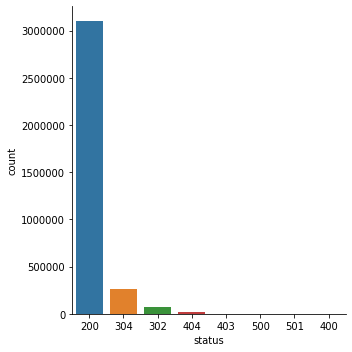

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

sns.catplot(x='status', y='count', data=status_freq_pd_df,
            kind='bar', order=status_freq_pd_df['status'])

Log Transformation to fix Skew

In [91]:
log_freq_df = status_freq_df.withColumn('log(count)',
                                        F.log(status_freq_df['count']))
log_freq_df.show()

+------+-------+------------------+
|status|  count|        log(count)|
+------+-------+------------------+
|   200|3100524|14.947081687429097|
|   302|  73070|11.199173164785263|
|   304| 266773|12.494153388502301|
|   400|     15|  2.70805020110221|
|   403|    225|  5.41610040220442|
|   404|  20899| 9.947456589918252|
|   500|     65| 4.174387269895637|
|   501|     41| 3.713572066704308|
+------+-------+------------------+



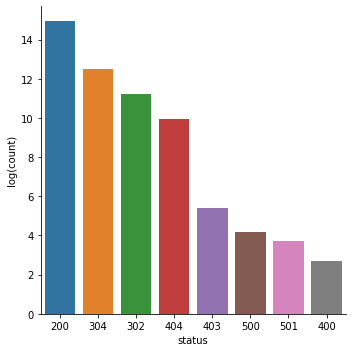

In [92]:
log_freq_pd_df = (log_freq_df
                    .toPandas()
                    .sort_values(by=['log(count)'],
                                 ascending=False))
sns.catplot(x='status', y='log(count)', data=log_freq_pd_df,
            kind='bar', order=status_freq_pd_df['status'])

Find Frequent Hosts

In [93]:
host_sum_df =(logs_df
               .groupBy('host')
               .count()
               .sort('count', ascending=False).limit(10))

host_sum_df.show(truncate=False)

+--------------------+-----+
|host                |count|
+--------------------+-----+
|piweba3y.prodigy.com|21988|
|piweba4y.prodigy.com|16437|
|piweba1y.prodigy.com|12825|
|edams.ksc.nasa.gov  |11964|
|163.206.89.4        |9697 |
|news.ti.com         |8161 |
|www-d1.proxy.aol.com|8047 |
|alyssa.prodigy.com  |8037 |
|                    |7660 |
|siltb10.orl.mmc.com |7573 |
+--------------------+-----+



Check Blank Record

In [94]:
host_sum_pd_df = host_sum_df.toPandas()
host_sum_pd_df.iloc[8]['host']

''

Frequent Endpoints

In [95]:
paths_df = (logs_df
            .groupBy('endpoint')
            .count()
            .sort('count', ascending=False).limit(20))

paths_pd_df = paths_df.toPandas()
paths_pd_df            

,endpoint,count
0,/images/NASA-logosmall.gif,208714
1,/images/KSC-logosmall.gif,164970
2,/images/MOSAIC-logosmall.gif,127908
3,/images/USA-logosmall.gif,127074
4,/images/WORLD-logosmall.gif,125925
5,/images/ksclogo-medium.gif,121572
6,/ksc.html,83909
7,/images/launch-logo.gif,76006
8,/history/apollo/images/apollo-logo1.gif,68896
9,/shuttle/countdown/,64736


Check top Error(non200) endpoints

In [96]:
not200_df = (logs_df
               .filter(logs_df['status'] != 200))

error_endpoints_freq_df = (not200_df
                               .groupBy('endpoint')
                               .count()
                               .sort('count', ascending=False)
                               .limit(10)
                          )
                         
error_endpoints_freq_df.show(truncate=False)  

+---------------------------------------+-----+
|endpoint                               |count|
+---------------------------------------+-----+
|/images/NASA-logosmall.gif             |40082|
|/images/KSC-logosmall.gif              |23763|
|/images/MOSAIC-logosmall.gif           |15245|
|/images/USA-logosmall.gif              |15142|
|/images/WORLD-logosmall.gif            |14773|
|/images/ksclogo-medium.gif             |13559|
|/images/launch-logo.gif                |8806 |
|/history/apollo/images/apollo-logo1.gif|7489 |
|/                                      |6296 |
|/images/ksclogosmall.gif               |5669 |
+---------------------------------------+-----+



In [50]:
not200_df.toPandas().to_csv('/users/userID/not200_.csv')

In [97]:
logs_df.toPandas().to_csv('/users/userid/logsdf.csv')

Check for SQL Injection

In [100]:
suspicious = ['union','select','passwd','password','/etc/passwd']

searchstr = '|'.join(suspicious)



In [115]:
SQL_INJ_df = (logs_df.filter(logs_df['Endpoint'].contains('1=1')))


SQL_INJ_df.show(truncate=False)  

+----+------+--------+--------+------+------------+----+
|host|method|endpoint|protocol|status|content_size|time|
+----+------+--------+--------+------+------------+----+
+----+------+--------+--------+------+------------+----+



In [113]:
SQL_INJ_df.summary().show()

+-------+--------------------+------+--------------------+--------+-----------------+------------------+
|summary|                host|method|            endpoint|protocol|           status|      content_size|
+-------+--------------------+------+--------------------+--------+-----------------+------------------+
|  count|                   8|     8|                   8|       8|                8|                 8|
|   mean|                null|  null|                null|    null|            225.5|           6159.25|
| stddev|                null|  null|                null|    null|72.12489168102785|2510.2857976163364|
|    min|       128.158.39.36|   GET|/htbin/wais.pl?as...|HTTP/1.0|              200|                 0|
|    25%|                null|  null|                null|    null|              200|              6252|
|    50%|                null|  null|                null|    null|              200|              7200|
|    75%|                null|  null|                nu

Analyze 404 Logs

In [116]:
is404_df = (logs_df.filter(logs_df['status'] == 404))

In [117]:
is404_df.toPandas().to_csv('/users/userid/is404.csv')

In [98]:
is403_df = (logs_df.filter(logs_df['status'] == 403))

error403_endpoints_freq_df = (is403_df
                               .groupBy('endpoint')
                               .count()
                               .sort('count', ascending=False)
                               .limit(10)
                          )
                         
error403_endpoints_freq_df.show(truncate=False)  

+--------------------------------------------------------+-----+
|endpoint                                                |count|
+--------------------------------------------------------+-----+
|/software/winvn/winvn.html/wvsmall.gif                  |35   |
|/software/winvn/winvn.html/bluemarb.gif                 |35   |
|/software/winvn/winvn.html/winvn.gif                    |35   |
|/ksc.html/images/ksclogo-medium.gif                     |12   |
|/ksc.html/images/NASA-logosmall.gif                     |10   |
|/ksc.html/facts/about_ksc.html                          |10   |
|/ksc.html/images/WORLD-logosmall.gif                    |10   |
|/ksc.html/images/USA-logosmall.gif                      |10   |
|/ksc.html/images/MOSAIC-logosmall.gif                   |10   |
|/ksc.html/shuttle/technology/sts-newsref/stsref-toc.html|5    |
+--------------------------------------------------------+-----+



Analyze 403 Logs

In [90]:

error403_host_freq_df = (is403_df
                               .groupBy('host')
                               .count()
                               .sort('count', ascending=False)
                               .limit(10)
                          )
                         
error403_host_freq_df.show(truncate=False)  

+----------------------------+-----+
|host                        |count|
+----------------------------+-----+
|163.135.192.101             |23   |
|tty18-23.swipnet.se         |21   |
|user36.znet.com             |21   |
|bass.hooked.net             |18   |
|rserio.charm.net            |12   |
|dialup539.washington.mci.net|12   |
|quasar.ed.niigata-u.ac.jp   |11   |
|foxlake.library.nwu.edu     |9    |
|erigate.ericsson.se         |6    |
|jcdbs.itsi.disa.mil         |6    |
+----------------------------+-----+



Analyze Non 200 Codes Part 2

In [94]:

error_host_freq_df = (not200_df
                               .groupBy('host')
                               .count()
                               .sort('count', ascending=False)
                               .limit(30)
                          )
                         
error_host_freq_df.show(truncate=False)  

+--------------------+-----+
|host                |count|
+--------------------+-----+
|disarray.demon.co.uk|3148 |
|163.205.156.16      |2130 |
|bill.ksc.nasa.gov   |2025 |
|www-d1.proxy.aol.com|1841 |
|www-c2.proxy.aol.com|1727 |
|www-b2.proxy.aol.com|1713 |
|www-b3.proxy.aol.com|1648 |
|www-c4.proxy.aol.com|1633 |
|www-c5.proxy.aol.com|1620 |
|www-b4.proxy.aol.com|1524 |
|www-d2.proxy.aol.com|1523 |
|www-c6.proxy.aol.com|1501 |
|www-c3.proxy.aol.com|1500 |
|www-d4.proxy.aol.com|1495 |
|www-a2.proxy.aol.com|1468 |
|www-c1.proxy.aol.com|1453 |
|www-d3.proxy.aol.com|1451 |
|www-b5.proxy.aol.com|1409 |
|www-a1.proxy.aol.com|1405 |
|piweba3y.prodigy.com|1321 |
+--------------------+-----+
only showing top 20 rows



In [170]:
##errorhostlist = ['disarray.demon.co.uk','163.205.156.16','bill.ksc.nasa.gov','www-d1.proxy.aol.com','www-c2.proxy.aol.com','piweba3y.prodigy.com']

errorhostlist = ['www-d1.proxy.aol.com']


error_host_df = logs_df[logs_df['host'].isin(errorhostlist)]

Endpoint Error count

In [171]:
errorhost_endpoints_freq_df = (error_host_df
                               .groupBy('endpoint')
                               .count()
                               .sort('count', ascending=False)
                               .limit(20)
                          )
                         
errorhost_endpoints_freq_df.show(truncate=False)  

+--------------------------------------------+-----+
|endpoint                                    |count|
+--------------------------------------------+-----+
|/images/NASA-logosmall.gif                  |232  |
|/                                           |223  |
|/images/                                    |200  |
|/images/KSC-logosmall.gif                   |199  |
|/images/USA-logosmall.gif                   |199  |
|/images/ksclogo-medium.gif                  |196  |
|/images/MOSAIC-logosmall.gif                |194  |
|/images/WORLD-logosmall.gif                 |178  |
|/history/apollo/images/apollo-logo1.gif     |173  |
|/images/launch-logo.gif                     |156  |
|/ksc.html                                   |148  |
|/shuttle/countdown/                         |142  |
|/icons/blank.xbm                            |138  |
|/icons/image.xbm                            |138  |
|/images/ksclogosmall.gif                    |137  |
|/icons/menu.xbm                             |

In [172]:
errorhost_day_df = error_host_df.select(error_host_df.host,
                             F.dayofyear('time').alias('day'))
host_day_df.show(5, truncate=False)

+-----------------+---+
|host             |day|
+-----------------+---+
|in24.inetnebr.com|1  |
|uplherc.upl.com  |1  |
|uplherc.upl.com  |1  |
|uplherc.upl.com  |1  |
|uplherc.upl.com  |1  |
+-----------------+---+
only showing top 5 rows



Daily Error Count

In [173]:
# def_mr = pd.get_option('max_rows')
pd.set_option('max_rows', 60)

daily_errorhosts1_df = (errorhost_day_df
                     .groupBy('day')
                     .count()
                     .sort("day"))

daily_errorhosts1_df = daily_errorhosts1_df.toPandas()
daily_errorhosts1_df

,day,count
0,182,170
1,183,224
2,184,214
3,185,263
4,186,142
5,187,112
6,188,163
7,189,248
8,190,97
9,191,106


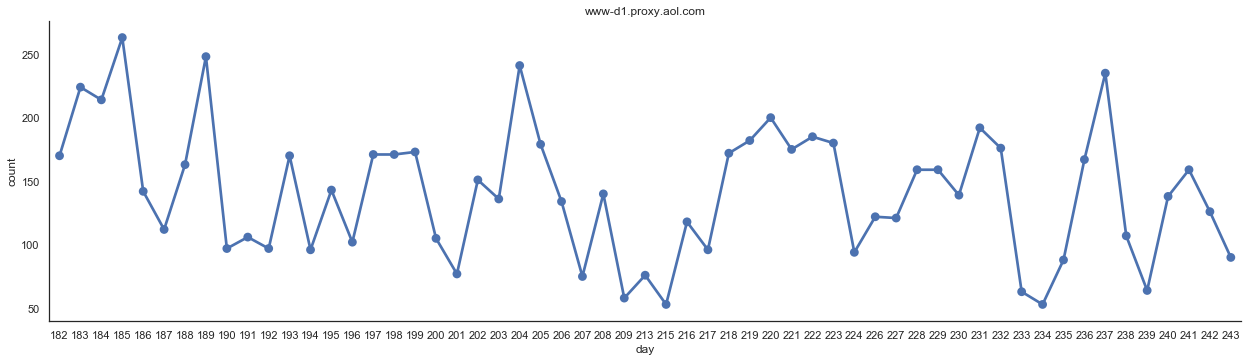

In [175]:
sns.set_style("white")


c = sns.catplot(x='day', y='count',
                data=daily_errorhosts1_df,
                kind='point', height=5,
                aspect=3.5).set(title='www-d1.proxy.aol.com')

Daily Web traffic Check

In [180]:
log_day_df = logs_df.select(logs_df.host,
                             F.dayofyear('time').alias('day'))




In [182]:
def_mr = pd.get_option('max_rows')
pd.set_option('max_rows', 10)

daily_logs_df = (log_day_df
                     .groupBy('day')
                     .count()
                     .sort("day"))

daily_logs_df = daily_logs_df.toPandas()
daily_logs_df

,day,count
0,182,64714
1,183,60265
2,184,89584
3,185,70452
4,186,94575
...,...,...
53,239,32823
54,240,55496
55,241,67988
56,242,80641


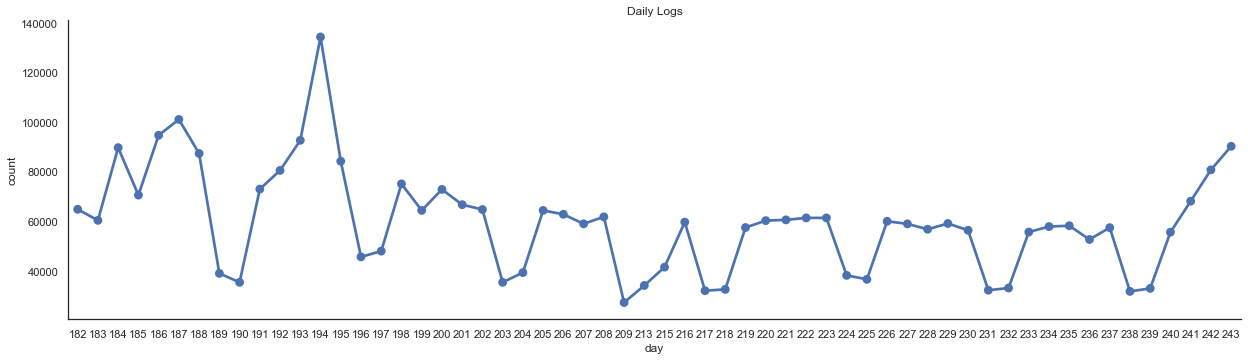

In [185]:
sns.set_style("white")


c = sns.catplot(x='day', y='count',
                data=daily_logs_df,
                kind='point', height=5,
                aspect=3.5).set(title='Daily Logs')

Unique Host Analysis

In [179]:
unique_host_count = (logs_df
                     .select('host')
                     .distinct()
                     .count())
unique_host_count

137933

In [61]:
host_day_df = logs_df.select(logs_df.host,
                             F.dayofmonth('time').alias('day'))
host_day_df.show(5, truncate=False)

+-----------------+---+
|host             |day|
+-----------------+---+
|in24.inetnebr.com|1  |
|uplherc.upl.com  |1  |
|uplherc.upl.com  |1  |
|uplherc.upl.com  |1  |
|uplherc.upl.com  |1  |
+-----------------+---+
only showing top 5 rows



In [62]:
host_day_distinct_df = logs_df.select(logs_df.host,
                             F.dayofmonth('time').alias('day')).distinct()


In [63]:
host_day_distinct_df.show(5, truncate=False)

+------------------------+---+
|host                    |day|
+------------------------+---+
|194.96.3.34             |1  |
|132.165.96.3            |1  |
|slip37-202.il.us.ibm.net|1  |
|199.1.50.225            |1  |
|ppp1004.po.iijnet.or.jp |1  |
+------------------------+---+
only showing top 5 rows



In [64]:
def_mr = pd.get_option('max_rows')
pd.set_option('max_rows', 10)

daily_hosts_df = (host_day_distinct_df
                     .groupBy('day')
                     .count()
                     .sort("day"))

daily_hosts_df = daily_hosts_df.toPandas()
daily_hosts_df

,day,count
0,1,7609
1,2,4858
2,3,10238
3,4,9411
4,5,9640
...,...,...
26,27,6846
27,28,6090
28,29,4825
29,30,5265


Graph by day of Month

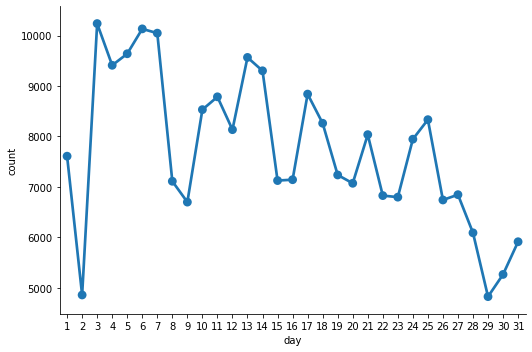

In [65]:
c = sns.catplot(x='day', y='count',
                data=daily_hosts_df,
                kind='point', height=5,
                aspect=1.5)

In [66]:
host_day_distinct_df2 = logs_df.select(logs_df.host,
                             F.dayofyear('time').alias('day')).distinct()


In [67]:
host_day_distinct_df2.show(5, truncate=False)

+--------------------------------------+---+
|host                                  |day|
+--------------------------------------+---+
|205.163.36.61                         |213|
|port42.ts2.msstate.edu                |213|
|roseanne06.slip.yorku.ca              |213|
|206.42.178.29                         |213|
|dorm2.ccit.edu.tw.132.140.in-addr.arpa|213|
+--------------------------------------+---+
only showing top 5 rows



In [68]:
def_mr = pd.get_option('max_rows')
pd.set_option('max_rows', 10)

daily_hosts_df2 = (host_day_distinct_df2
                     .groupBy('day')
                     .count()
                     .sort("day"))

daily_hosts_df2 = daily_hosts_df2.toPandas()
daily_hosts_df2

,day,count
0,182,5191
1,183,4858
2,184,7332
3,185,5523
4,186,7379
...,...,...
53,239,2690
54,240,4213
55,241,4825
56,242,5265


Graph by Day of Year

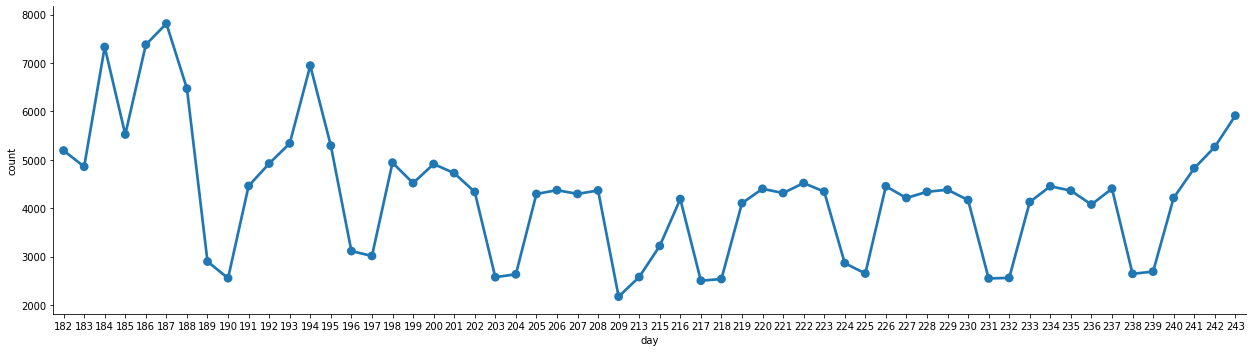

In [69]:
c = sns.catplot(x='day', y='count',
                data=daily_hosts_df2,
                kind='point', height=5,
                aspect=3.5)

In [70]:
host_day_distinct_df3 = logs_df.select(logs_df.host,
                             F.dayofweek('time').alias('day')).distinct()


In [71]:
host_day_distinct_df3.show(5, truncate=False)

+-------------------------+---+
|host                     |day|
+-------------------------+---+
|hayes.worldgate.com      |3  |
|dial3-15.midwest.net     |3  |
|128.159.111.138          |3  |
|ts900-1625.singnet.com.sg|3  |
|n1043354.ksc.nasa.gov    |3  |
+-------------------------+---+
only showing top 5 rows



In [72]:
def_mr = pd.get_option('max_rows')
pd.set_option('max_rows', 10)

daily_hosts_df3 = (host_day_distinct_df3
                     .groupBy('day')
                     .count()
                     .sort("day"))

daily_hosts_df3 = daily_hosts_df3.toPandas()
daily_hosts_df3

,day,count
0,1,20708
1,2,30834
2,3,31859
3,4,32404
4,5,36538
5,6,28513
6,7,21251


Visualization of Day of Week

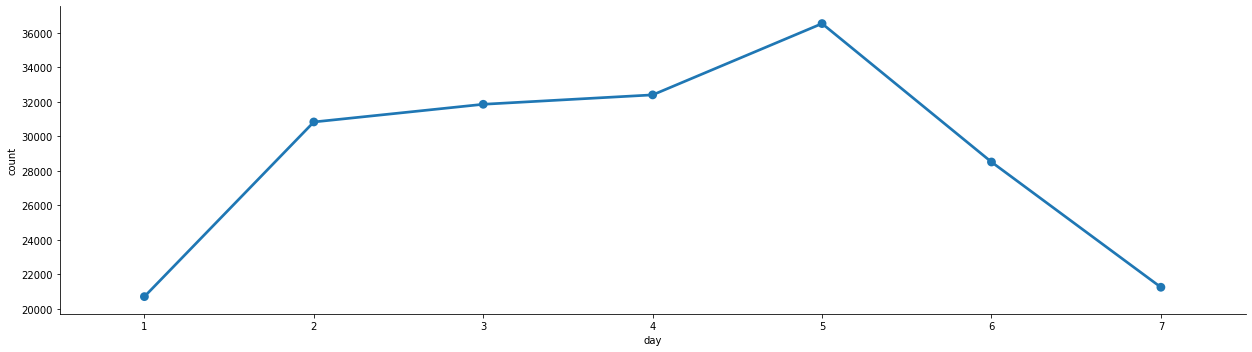

In [73]:
c = sns.catplot(x='day', y='count',
                data=daily_hosts_df3,
                kind='point', height=5,
                aspect=3.5)

In [74]:
daily_hosts_df = (host_day_distinct_df
                     .groupBy('day')
                     .count()
                     .select(col("day"),
                                      col("count").alias("total_hosts")))

total_daily_reqests_df = (logs_df
                              .select(F.dayofmonth("time")
                                          .alias("day"))
                              .groupBy("day")
                              .count()
                              .select(col("day"),
                                      col("count").alias("total_reqs")))

avg_daily_reqests_per_host_df = total_daily_reqests_df.join(daily_hosts_df, 'day')
avg_daily_reqests_per_host_df = (avg_daily_reqests_per_host_df
                                    .withColumn('avg_reqs', col('total_reqs') / col('total_hosts'))
                                    .sort("day"))
avg_daily_reqests_per_host_df = avg_daily_reqests_per_host_df.toPandas()
avg_daily_reqests_per_host_df

,day,total_reqs,total_hosts,avg_reqs
0,1,98710,7609,12.972795
1,2,60265,4858,12.405311
2,3,130972,10238,12.792733
3,4,130009,9411,13.814579
4,5,126468,9640,13.119087
...,...,...,...,...
26,27,94503,6846,13.804119
27,28,82617,6090,13.566010
28,29,67988,4825,14.090777
29,30,80641,5265,15.316429


Average Requests

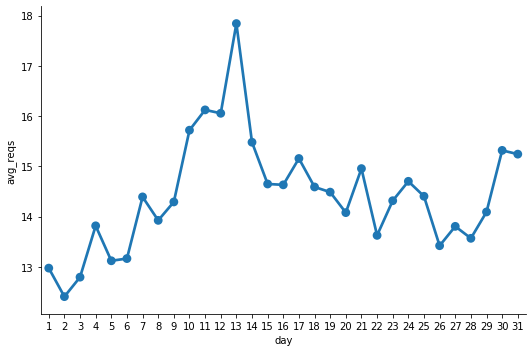

In [75]:
c = sns.catplot(x='day', y='avg_reqs',
                data=avg_daily_reqests_per_host_df,
                kind='point', height=5, aspect=1.5)

In [76]:
not_found_df = logs_df.filter(logs_df["status"] == 404).cache()
print(('Total 404 responses: {}').format(not_found_df.count()))

Total 404 responses: 20899


404 Endpoint Analysis

In [ ]:
endpoints_404_count_df = (not_found_df
                          .groupBy("endpoint")
                          .count()
                          .sort("count", ascending=False)
                          .limit(20))

endpoints_404_count_df.show(truncate=False)

404 Host Analysis

In [78]:
hosts_404_count_df = (not_found_df
                          .groupBy("host")
                          .count()
                          .sort("count", ascending=False)
                          .limit(20))

hosts_404_count_df.show(truncate=False)

+---------------------------+-----+
|host                       |count|
+---------------------------+-----+
|hoohoo.ncsa.uiuc.edu       |251  |
|piweba3y.prodigy.com       |157  |
|jbiagioni.npt.nuwc.navy.mil|132  |
|piweba1y.prodigy.com       |114  |
|                           |112  |
|www-d4.proxy.aol.com       |91   |
|piweba4y.prodigy.com       |86   |
|scooter.pa-x.dec.com       |69   |
|www-d1.proxy.aol.com       |64   |
|phaelon.ksc.nasa.gov       |64   |
|www-b4.proxy.aol.com       |62   |
|dialip-217.den.mmc.com     |62   |
|www-b3.proxy.aol.com       |61   |
|www-a2.proxy.aol.com       |60   |
|www-d2.proxy.aol.com       |59   |
|piweba2y.prodigy.com       |59   |
|alyssa.prodigy.com         |56   |
|monarch.eng.buffalo.edu    |56   |
|www-b2.proxy.aol.com       |53   |
|www-c4.proxy.aol.com       |53   |
+---------------------------+-----+



Errors by day of Month

In [79]:
errors_by_date_sorted_df = (not_found_df
                                .groupBy(F.dayofmonth('time').alias('day'))
                                .count()
                                .sort("day"))

errors_by_date_sorted_pd_df = errors_by_date_sorted_df.toPandas()
errors_by_date_sorted_pd_df

,day,count
0,1,559
1,2,291
2,3,778
3,4,705
4,5,733
...,...,...
26,27,706
27,28,504
28,29,420
29,30,571


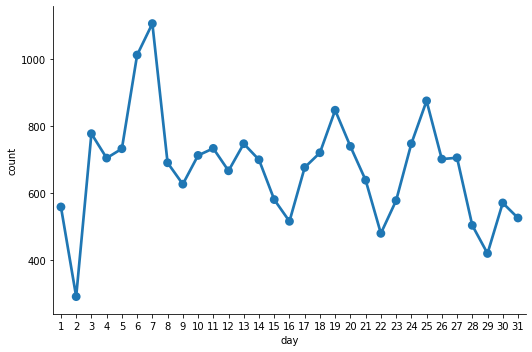

In [80]:
c = sns.catplot(x='day', y='count',
                data=errors_by_date_sorted_pd_df,
                kind='point', height=5, aspect=1.5)

In [81]:
(errors_by_date_sorted_df
    .sort("count", ascending=False)
    .show(3))

+---+-----+
|day|count|
+---+-----+
|  7| 1107|
|  6| 1013|
| 25|  876|
+---+-----+
only showing top 3 rows



Cool Visualization of Hourly Errors (404)

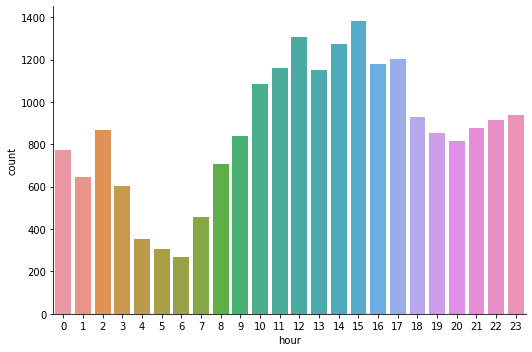

In [82]:
hourly_avg_errors_sorted_df = (not_found_df
                                   .groupBy(F.hour('time')
                                             .alias('hour'))
                                   .count()
                                   .sort('hour'))
hourly_avg_errors_sorted_pd_df = hourly_avg_errors_sorted_df.toPandas()

c = sns.catplot(x='hour', y='count',
                data=hourly_avg_errors_sorted_pd_df,
                kind='bar', height=5, aspect=1.5)

THE END